In [1]:
import torch
import torchvision
import time
from torch import optim, nn
from importlib import reload
import numpy as np


import GPUtil

import sys, os
sys.path.insert(0,'..')

#############################################
## Copy of Inceptionv3, slightly modified for recording intermeridates
#sys.path.append('/home/cshetty2/sct/pytorch')
#import reformated_models.inception_modified as inception_modified

## Modified Alexnet, with a'factor' by which it can be made 'fat' 
#import simple_model as sm

## Placer libs of baechi
#sys.path.append('/home/cshetty2/sct')
#from placer.placer_lib import *
##############################################

#import dummyModels as dm
import baechiTest_dummyModels as dm


######## For profiler (some experiments. Not required) #################
from torch.profiler import profile, record_function, ProfilerActivity


import matplotlib.pyplot as plt

######## For debug purposes ONLY ########
import ctypes, gc
import psutil, os

###############################Utilities#################################
### From https://discuss.pytorch.org/t/how-pytorch-releases-variable-garbage/7277
def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size())
    
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)
        
## Print memory of all available GPU's
def print_gpu_memory():
    for i in range(torch.cuda.device_count()):
        #print(torch.cuda.get_device_name(i))
        print("GPU:", i)
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(i)/1024**3,8), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(i)/1024**3,8), 'GB')
        #print("-----------------")
        #GPUtil.showUtilization()
        print("-----------")
        
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')
    sys._jupyter_stdout = sys.stdout

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__
#########################################

%matplotlib inline
%load_ext autoreload
%autoreload 2

print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


In [2]:
import threading
from random import expovariate

In [3]:
from baechi_units_bigbrain import *

Experiment aims to demonstrate the advantage of packing training jobs on GPU (based on the resource requirements) rather than allotting integer number of GPUs per job (as container based approach would do)

Measure: Throughput for these two cases and compare:
- (1) one GPU allocation for each incoming jobs on FCFS basis
- (2) decide a split of the incoming model among the two GPUs and run on best effort basis (the entire model maybe placed on one GPUs)

Expectation: (2) should be more than (1) for two reasons:
- granualr GPU allocation is more efficient
- the model choosen itself runs faster when split across 2 gpus than 1 as described in next section

Primitives:

- GPUs : Setup consists of only 2 GPUs on one node
- Jobs : All incoming jobs will be of same kind - to train a model dm.parallelModelThreeLayerSplit as described below
- Training Script: run_train() is the main training routine. When a job arrives, a split for the model among two GPU's is 
- Job queue: jobs arrive as poisson process. Job queue maintains the cluster state and allots jobs with appropriate split while preventing OOMs

In [4]:
def get_model(model_name, fct, repetable): 
    if model_name == "inception_v3":
        model = inception_modified.inception_v3(pretrained=True)
        inp_size_single = (3, 299, 299)
        opt_size = 1000

    if model_name == "TallParallelModel":
        factor = fct
        inp_size_single = (1, 512*factor)
        model = dm.tallParallelModel(factor, repetable)
        opt_size = 1000


    if model_name == "ParallelTwoLayer":
        factor = fct
        inp_size_single = (1, int(512*factor))
        model = dm.parallelTwoLayer(factor, repetable)
        opt_size = 512*fct

    if model_name == "ParallelThreeLayer":
        factor = fct
        inp_size_single = (1, int(512*factor))
        model = dm.parallelThreeLayer(factor, repetable)
        opt_size = 512*fct
        
    return model, inp_size_single, opt_size
  

### Training script

In [5]:
def run_train(model, batch_size, Nrun, inp_size_single, opt_size, \
              first_gpu, final_gpu ):     

    optimizer = optim.SGD(model.parameters(), lr = 0.0001); 
    criterion = nn.MSELoss()
    dataset = torchvision.datasets.FakeData(
        size= Nrun * batch_size,
        image_size=inp_size_single,
        num_classes=opt_size,
        transform=torchvision.transforms.ToTensor())
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    result = []

    times = []
    for batch_idx, (inp, oup) in enumerate(data_loader):
        ### TODO: Remove this all-device sync by running each job in a stream
        #torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
        labels = torch.randn((batch_size,opt_size)).to(final_gpu)
        start = time.time()
        inp = inp.to(first_gpu); 
        optimizer.zero_grad()
        output = model(inp)
        #torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
        ######################### loss compute ################################################
        loss = criterion(output, labels )
        ##################################################################################
        loss.backward(loss)
        optimizer.step()
        #torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
        end = time.time()
        times.append(1000*(end-start))
    if len(times)>10:
        gpu_time = np.mean(times[10:])
    else:
        gpu_time = True
    
    #### Release memory
    del inp
    del output
    try:
        del labels
        del optimizer
        del loss
    except: pass

    return gpu_time


In [6]:
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


In [7]:
####################### GLOBALS #####################################3

### dict of (gpu_id, fraction of gpu available)
resource_manager   = {}  
resource_manager[1]= 1
resource_manager[2]= 1

### dict of job_id -> dict{model_split, status_flag, arrival_time, entry_time, exit_time}
job_queue          = {}  

end_exp_flag = [0] #flag to indicate end of experiment

In [8]:
def get_split_algo_1():
    if resource_manager[1] == 1:
        return [1,1]
    elif resource_manager[2] == 1:
        return [2,2]
    else:
        return None   

In [9]:
def get_split_algo_2():
    if resource_manager[1] > 0.5:
        return [1,1]
    elif resource_manager[2] > 0.5:
        return [2,2]
    elif (resource_manager[1] > 0.2 and resource_manager[2] > 0.2):
        return [1,2]
    return None

In [10]:
def update_resource(split, update_type):
    if update_type == "release":
        change =  1.0
    elif update_type == "acquire":
        change = -1.0
     
    if split == [1,1]:
        resource_manager[1] = resource_manager[1] + 0.7*change
    elif split == [2,2]:
        resource_manager[2] = resource_manager[2] + 0.7*change
    elif split == [1,2]:
        resource_manager[1] = resource_manager[1] + 0.3*change
        resource_manager[2] = resource_manager[2] + 0.3*change
    else:
        print("Error! split is invalid")
    

In [11]:
def run_job(job_id, algo, model_name, fct, batch_size, Nrun, done_flag, exit_time ): 
    
    repetable = 0
    model, inp_size_single, opt_size = get_model(model_name, fct, repetable)
    
    inp_size = (batch_size,) + inp_size_single
    out_size = (batch_size, opt_size)
    
    available_gpus = [1,2]
    args.batch_size = str(batch_size)
    
    if algo == 'baseline':
        gpu_id = job_queue[job_id]['model_split'][0]
        model = model.to(gpu_id)
        avg_gpu_time = run_train(model, batch_size, Nrun, inp_size_single, opt_size, \
                  gpu_id, gpu_id)
        del model
        gc.collect()              ## To clean any circular references
        torch.cuda.empty_cache()
        
    
    if algo == 'baechi':
        ################################################################################
        return_graph, tester = build_graph(model, batch_size,args.prof_gpu_id, args.prof_rounds, inp_size = inp_size_single)
        available_device_list = {k:device_list[k] for k in available_gpus}
        DEVICE_GRAPH_MULTIPLE = create_device_graph(available_device_list)

        placed_op_graph = m_topo(return_graph, DEVICE_GRAPH_MULTIPLE)
        copy_p(return_graph, tester)
        #########################################################
        resource_usage = {gpu_id:0 for gpu_id in available_gpus}
        first_gpu = -1
        for node_id in tester.sub_module_nodes:
            node = tester.sub_module_nodes[node_id]
            curr_gpu_id    = node.p
            if first_gpu < 0:
                first_gpu = curr_gpu_id
            curr_res_usage = node.input_memory + node.persistent_memory \
                            + node.temporary_memory
            resource_usage[curr_gpu_id] += curr_res_usage
            #print("layer:", node.module)
            #print("gpu:", curr_gpu_id, ", resource:", curr_res_usage)
        final_gpu = curr_gpu_id
        #print()
        print("Net Resource:", resource_usage)
        #print([resource_usage[gpu_id]/device_list[gpu_id]['memory_size'] for gpu_id in available_gpus])
        #print('-'*30)
        #[resource_usage[gpu_id]/device_list[gpu_id]['memory_size'] for gpu_id in available_gpus]
        
        ######################################################

        Assign(tester)

        avg_gpu_time = run_train(tester.model, batch_size, Nrun, inp_size_single, opt_size, \
                  first_gpu, final_gpu )
        ################################################################################
        del tester
        del placed_op_graph
        del return_graph
        gc.collect()              ## To clean any circular references
        torch.cuda.empty_cache() ## Empty cache used by Pytorch (does so across all threads)

    done_flag[0] = avg_gpu_time
    exit_time[0] = time.time()
    #print_gpu_memory()
    print("Mean time taken:", avg_gpu_time)

    return 0
    

In [12]:
def job_arrivals(rate, T_exp):
    exp_start_time  = time.time()
    t = exp_start_time 
    job_id = 0
    
    while t < exp_start_time + T_exp:
        time.sleep(expovariate(rate))
        job_id = job_id+1
        job_queue[job_id] = {'model_split':None, 'status_flag':[0], \
                             'arrival_time':[time.time()], 'entry_time':[0], 'exit_time':[0]}
        t = time.time()
        
    end_exp_flag[0] = 1
    return 0

In [13]:
############### MAIN #########################

T_exp      = 100        # (in sec) Time for which the exp will run
rate       = 0.2         # job arrival rate
Nrun       = 300      
batch_size = 32
fct        = 6

job_server = threading.Thread(target=job_arrivals, args=(rate, T_exp, ))
job_server.start()

job_served     = 0
jobs_in_process = []
jobs_completed = [] 
no_jobs_waiting = []

t = time.time()
while not end_exp_flag[0]:
    try: 
        ## Check if a new job arrived. Will fail if no new job
        new_job = job_queue[job_served+1] 
        
        #print(job_served+1)
        #print(job_queue)
        
        if (new_job['entry_time'][0]):
            print("Something went wrong! New job already has entry time")
        
        ## get a resource allocation for new job
        
        #split = get_split_algo_1()
        #algo = 'baseline'
        
        split = get_split_algo_2()
        algo = 'baechi'
        
        model_name = "ParallelThreeLayer"
        
        
        ## If resource is available then a split is returned 
        ## Else just wait
        if split:   
            new_job['model_split'] = split
            ### Update resources
            update_resource(split, 'acquire')
            if resource_manager[1]<0 or resource_manager[2]<0:
                print("Error! There's nothing like negative resources!")
            
            ### Spawn a thread to start the new job
            new_job['entry_time'][0]  = time.time()

            job_submit = threading.Thread(target=run_job, args=(job_served+1, algo, model_name, fct, \
                                                                  batch_size, Nrun, new_job['status_flag'], \
                                                                  new_job['exit_time'], ))
            job_submit.start()
            job_served = job_served+1
            jobs_in_process.append(job_served)
            
        else:
            pass
        
        
    except:
        pass
    
    completed = []
    for inprocess_job_id in jobs_in_process:
        if job_queue[inprocess_job_id]['status_flag'][0]:
            completed.append(inprocess_job_id)   
            ## Release resources
            update_resource(job_queue[inprocess_job_id]['model_split'], 'release')
    
    jobs_completed = jobs_completed +  completed 
    for i in completed:
        jobs_in_process.remove(i)
        
    t_now = time.time()
    if t_now-t>1:
        ## Check for completed jobs 
        no_waiting = len(job_queue)-job_served
        no_jobs_waiting.append(no_waiting)
        print('*-'*20)
        print("Jobs in process:", len(jobs_in_process))
        print("Jobs waiting:",no_waiting )
        print("Jobs Completed: ", len(jobs_completed))
        print('*-'*20)
        t = t_now
        

    time.sleep(0.1)
    

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 0
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 0
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 0
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 0
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 0
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 0
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 0
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in

/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32, 3072])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/cuda/memory.py:263: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


2021-12-14 20:41:30,128 - m_topo:80 - INFO - required memory=834.14MB, max op memory=145.55MB
2021-12-14 20:41:30,129 - m_topo:94 - INFO - Max memory per device: 562.62MB
2021-12-14 20:41:30,131 - m_topo:65 - INFO - Topo placement stats
2021-12-14 20:41:30,132 - placer_utils:380 - INFO - device: 1, # ops: 5, # groups: 1, computation time: 4 us, temp memory: 0B, persistent memory: 468.08MB
2021-12-14 20:41:30,132 - placer_utils:380 - INFO - device: 2, # ops: 6, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 360.06MB


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Net Resource: {1: 495144960.0, 2: 382660608.0}


2021-12-14 20:41:30,704 - m_topo:80 - INFO - required memory=834.14MB, max op memory=145.55MB
2021-12-14 20:41:30,705 - m_topo:94 - INFO - Max memory per device: 562.62MB
2021-12-14 20:41:30,706 - m_topo:65 - INFO - Topo placement stats
2021-12-14 20:41:30,707 - placer_utils:380 - INFO - device: 1, # ops: 5, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 468.08MB
2021-12-14 20:41:30,708 - placer_utils:380 - INFO - device: 2, # ops: 6, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 360.06MB


Net Resource: {1: 495144960.0, 2: 382660608.0}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


2021-12-14 20:41:37,979 - m_topo:80 - INFO - required memory=834.14MB, max op memory=145.55MB
2021-12-14 20:41:37,980 - m_topo:94 - INFO - Max memory per device: 562.62MB
2021-12-14 20:41:37,982 - m_topo:65 - INFO - Topo placement stats
2021-12-14 20:41:37,983 - placer_utils:380 - INFO - device: 1, # ops: 4, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 432.07MB
2021-12-14 20:41:37,984 - placer_utils:380 - INFO - device: 2, # ops: 7, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 396.07MB


Net Resource: {1: 456990720.0, 2: 420814848.0}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
M

2021-12-14 20:41:46,804 - m_topo:80 - INFO - required memory=834.14MB, max op memory=145.55MB
2021-12-14 20:41:46,806 - m_topo:94 - INFO - Max memory per device: 562.62MB
2021-12-14 20:41:46,806 - m_topo:65 - INFO - Topo placement stats
2021-12-14 20:41:46,807 - placer_utils:380 - INFO - device: 1, # ops: 6, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 504.09MB
2021-12-14 20:41:46,808 - placer_utils:380 - INFO - device: 2, # ops: 5, # groups: 1, computation time: 1 us, temp memory: 0B, persistent memory: 324.05MB


Net Resource: {1: 533299200.0, 2: 344506368.0}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  2
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  2
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  2
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  2
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  2
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  2
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


2021-12-14 20:41:53,297 - m_topo:80 - INFO - required memory=834.14MB, max op memory=145.55MB
2021-12-14 20:41:53,299 - m_topo:94 - INFO - Max memory per device: 562.62MB
2021-12-14 20:41:53,300 - m_topo:65 - INFO - Topo placement stats
2021-12-14 20:41:53,301 - placer_utils:380 - INFO - device: 1, # ops: 5, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 468.08MB
2021-12-14 20:41:53,303 - placer_utils:380 - INFO - device: 2, # ops: 6, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 360.06MB


Net Resource: {1: 495144960.0, 2: 382660608.0}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  2
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  2
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Mean time taken: 13.50250244140625
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  3
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


2021-12-14 20:41:56,369 - m_topo:80 - INFO - required memory=834.14MB, max op memory=145.55MB
2021-12-14 20:41:56,371 - m_topo:94 - INFO - Max memory per device: 562.62MB
2021-12-14 20:41:56,372 - m_topo:65 - INFO - Topo placement stats
2021-12-14 20:41:56,373 - placer_utils:380 - INFO - device: 1, # ops: 5, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 468.08MB
2021-12-14 20:41:56,374 - placer_utils:380 - INFO - device: 2, # ops: 6, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 360.06MB


Net Resource: {1: 495144960.0, 2: 382660608.0}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  3
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  3
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  3
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  3
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 2
Jobs Completed:  3
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 2
Jobs Completed:  3
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 2
Jobs Completed:  3
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
M

2021-12-14 20:42:05,505 - m_topo:80 - INFO - required memory=834.14MB, max op memory=145.55MB
2021-12-14 20:42:05,508 - m_topo:94 - INFO - Max memory per device: 562.62MB
2021-12-14 20:42:05,509 - m_topo:65 - INFO - Topo placement stats
2021-12-14 20:42:05,510 - placer_utils:380 - INFO - device: 1, # ops: 5, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 468.08MB
2021-12-14 20:42:05,511 - placer_utils:380 - INFO - device: 2, # ops: 6, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 360.06MB


Net Resource: {1: 495144960.0, 2: 382660608.0}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 2
Jobs Completed:  4
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 2
Jobs Completed:  4
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 2
Jobs Completed:  4
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 2
Jobs Completed:  4
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 3
Jobs Completed:  4
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 3
Jobs Completed:  4
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process:Mean time taken: 11.096054110033759
 3
Jobs waiting: 3
Jobs Completed:  4
*-*-*-

2021-12-14 20:42:13,780 - m_topo:80 - INFO - required memory=834.14MB, max op memory=145.55MB
2021-12-14 20:42:13,783 - m_topo:94 - INFO - Max memory per device: 562.62MB
2021-12-14 20:42:13,784 - m_topo:65 - INFO - Topo placement stats
2021-12-14 20:42:13,785 - placer_utils:380 - INFO - device: 1, # ops: 5, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 468.08MB
2021-12-14 20:42:13,786 - placer_utils:380 - INFO - device: 2, # ops: 6, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 360.06MB


Net Resource: {1: 495144960.0, 2: 382660608.0}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 2
Jobs Completed:  5
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Mean time taken: 11.146137632172683
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  6
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  6
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


2021-12-14 20:42:16,759 - m_topo:80 - INFO - required memory=834.14MB, max op memory=145.55MB
2021-12-14 20:42:16,761 - m_topo:94 - INFO - Max memory per device: 562.62MB
2021-12-14 20:42:16,763 - m_topo:65 - INFO - Topo placement stats
2021-12-14 20:42:16,764 - placer_utils:380 - INFO - device: 1, # ops: 5, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 468.08MB
2021-12-14 20:42:16,765 - placer_utils:380 - INFO - device: 2, # ops: 6, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 360.06MB


Net Resource: {1: 495144960.0, 2: 382660608.0}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  6
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  6
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  6
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  6
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  6
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  6
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  6
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
M

2021-12-14 20:42:25,447 - m_topo:80 - INFO - required memory=834.14MB, max op memory=145.55MB
2021-12-14 20:42:25,449 - m_topo:94 - INFO - Max memory per device: 562.62MB
2021-12-14 20:42:25,450 - m_topo:65 - INFO - Topo placement stats
2021-12-14 20:42:25,451 - placer_utils:380 - INFO - device: 1, # ops: 4, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 432.07MB
2021-12-14 20:42:25,452 - placer_utils:380 - INFO - device: 2, # ops: 7, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 396.07MB


Net Resource: {1: 456990720.0, 2: 420814848.0}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  7
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  7
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  7
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  7
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  7
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  7
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 1
Jobs Completed:  7
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
M

2021-12-14 20:42:33,630 - m_topo:80 - INFO - required memory=834.14MB, max op memory=145.55MB
2021-12-14 20:42:33,631 - m_topo:94 - INFO - Max memory per device: 562.62MB
2021-12-14 20:42:33,632 - m_topo:65 - INFO - Topo placement stats
2021-12-14 20:42:33,633 - placer_utils:380 - INFO - device: 1, # ops: 5, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 468.08MB
2021-12-14 20:42:33,634 - placer_utils:380 - INFO - device: 2, # ops: 6, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 360.06MB


Net Resource: {1: 495144960.0, 2: 382660608.0}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  8
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  Mean time taken:8
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
 13.58115919705095
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  9
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  9
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


2021-12-14 20:42:37,840 - m_topo:80 - INFO - required memory=834.14MB, max op memory=145.55MB
2021-12-14 20:42:37,842 - m_topo:94 - INFO - Max memory per device: 562.62MB
2021-12-14 20:42:37,843 - m_topo:65 - INFO - Topo placement stats
2021-12-14 20:42:37,844 - placer_utils:380 - INFO - device: 1, # ops: 4, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 432.07MB
2021-12-14 20:42:37,846 - placer_utils:380 - INFO - device: 2, # ops: 7, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 396.07MB


Net Resource: {1: 456990720.0, 2: 420814848.0}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  9
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  9
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  9
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  9
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  9
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  9
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Mean time taken: 14.1479072899654
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  10
*-*-*-*

2021-12-14 20:42:50,804 - m_topo:80 - INFO - required memory=834.14MB, max op memory=145.55MB
2021-12-14 20:42:50,805 - m_topo:94 - INFO - Max memory per device: 562.62MB
2021-12-14 20:42:50,805 - m_topo:65 - INFO - Topo placement stats
2021-12-14 20:42:50,805 - placer_utils:380 - INFO - device: 1, # ops: 5, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 468.08MB
2021-12-14 20:42:50,806 - placer_utils:380 - INFO - device: 2, # ops: 6, # groups: 1, computation time: 1 us, temp memory: 0B, persistent memory: 360.06MB


Mean time taken: 9.792539991181473
Net Resource: {1: 495144960.0, 2: 382660608.0}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 1
Jobs waiting: 0
Jobs Completed:  12
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 2
Jobs waiting: 0
Jobs Completed:  12
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 0
Jobs Completed:  12
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 2
Jobs Completed:  12
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


2021-12-14 20:42:55,226 - m_topo:80 - INFO - required memory=834.14MB, max op memory=145.55MB
2021-12-14 20:42:55,228 - m_topo:94 - INFO - Max memory per device: 562.62MB
2021-12-14 20:42:55,230 - m_topo:65 - INFO - Topo placement stats
2021-12-14 20:42:55,232 - placer_utils:380 - INFO - device: 1, # ops: 4, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 432.07MB
2021-12-14 20:42:55,234 - placer_utils:380 - INFO - device: 2, # ops: 7, # groups: 1, computation time: 3 us, temp memory: 36.39MB, persistent memory: 396.07MB


Net Resource: {1: 456990720.0, 2: 458969088.0}


2021-12-14 20:42:55,459 - m_topo:80 - INFO - required memory=834.14MB, max op memory=145.55MB
2021-12-14 20:42:55,460 - m_topo:94 - INFO - Max memory per device: 562.62MB
2021-12-14 20:42:55,461 - m_topo:65 - INFO - Topo placement stats
2021-12-14 20:42:55,462 - placer_utils:380 - INFO - device: 1, # ops: 5, # groups: 1, computation time: 3 us, temp memory: 0B, persistent memory: 468.08MB
2021-12-14 20:42:55,462 - placer_utils:380 - INFO - device: 2, # ops: 6, # groups: 1, computation time: 3 us, temp memory: 0B, persistent memory: 360.06MB


Net Resource: {1: 495144960.0, 2: 382660608.0}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 2
Jobs Completed:  12
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 3
Jobs Completed:  12
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 3
Jobs Completed:  12
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 4
Jobs Completed:  12
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 4
Jobs Completed:  12
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 4
Jobs Completed:  12
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 3
Jobs waiting: 4
Jobs Completed:  12
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

2021-12-14 20:43:08,717 - m_topo:80 - INFO - required memory=834.14MB, max op memory=145.55MB
2021-12-14 20:43:08,718 - m_topo:94 - INFO - Max memory per device: 562.62MB
2021-12-14 20:43:08,720 - m_topo:65 - INFO - Topo placement stats
2021-12-14 20:43:08,721 - placer_utils:380 - INFO - device: 1, # ops: 6, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 504.09MB
2021-12-14 20:43:08,722 - placer_utils:380 - INFO - device: 2, # ops: 5, # groups: 1, computation time: 2 us, temp memory: 0B, persistent memory: 324.05MB


Net Resource: {1: 533299200.0, 2: 344506368.0}


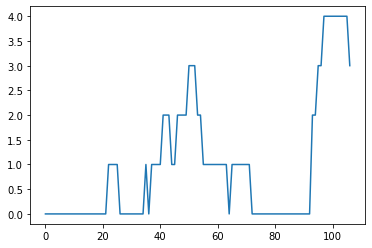

In [14]:
plt.plot(no_jobs_waiting)

plt.show()

In [15]:
process_time  = []
waiting_time = []
for job in job_queue:
    if job_queue[job]['status_flag'][0]:
        waiting_time.append(job_queue[job]['entry_time'][0] - job_queue[job]['arrival_time'][0])
        process_time.append(job_queue[job]['exit_time'][0] - job_queue[job]['entry_time'][0])

print("Mean Waiting Time: ", np.mean(waiting_time))
print("Mean Process Time: ", np.mean(process_time))
    

Mean Waiting Time:  4.276781100493211
Mean Process Time:  18.407396958424496
Mean time taken: 13.889653107215619
Mean time taken: 17.191648483276367
Mean time taken: 12.28213228028396
